## **Machine Learning Final Assessment**


In [ ]:
#importing the aif360 library

!pip install aif360

In [ ]:
#importing the fairlearn library
#prevents errors when importing 

! pip install fairlearn

In [3]:
cd	/usr/local/lib/python3.7/dist-packages/aif360/data/raw/adult

/usr/local/lib/python3.7/dist-packages/aif360/data/raw/adult


In [ ]:
#adult dataset import 

!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test
!wget	https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names

In [5]:
cd /usr/local/lib/python3.7/dist-packages/aif360/data/raw/german

/usr/local/lib/python3.7/dist-packages/aif360/data/raw/german


In [ ]:
#german dataset import

!wget	https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data
!wget	https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.doc

In [7]:
#imports for the assignment

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import os
import glob
import random
from numpy.random import RandomState
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import pdb

from IPython.display import display

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans 
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import *
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, f1_score

from aif360.datasets import BinaryLabelDataset
from aif360.datasets import AdultDataset, GermanDataset 
from aif360.sklearn.datasets import fetch_adult
from aif360.sklearn.metrics import disparate_impact_ratio, average_odds_error, generalized_fpr, equal_opportunity_difference

from aif360.algorithms.preprocessing.reweighing import Reweighing
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_adult, load_preproc_data_german
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric

#setting random seed as the beginning of my candidate number
np.random.seed(244)

## Splitting into Test and Train

### Functions

In [8]:
#function to split and normalise each dataset

def splitdata (dataset):

  #sensitive attributes
  privileged_groups = [{'sex': 1}]
  unprivileged_groups = [{'sex': 0}]
  dataset_orig = dataset(['sex'])

  #splitting into test and train
  train, test = dataset_orig.split([0.7], shuffle=True)
  print("training data size", train.features.shape)
  print("dataset feature names", train.feature_names)

  #normalising the dataset
  scale_orig = StandardScaler()
  X_train = scale_orig.fit_transform(train.features)
  y_train = train.labels.ravel()

  X_test = scale_orig.transform(test.features) 
  y_test = test.labels.ravel()

  #getting to know the dataset
  #exploration step

  #shapes of each dataset
  print('The whole adult dataset shape is ' + str(dataset_orig.features.shape))
  print('The training adult dataset shape is ' + str(train.features.shape))
  print('The testing adult dataset shape is ' + str(test.features.shape))

  #printing the attributes and labels
  print('Favourable label is ' + str(train.favorable_label) +' and unfavourable label is '+ str(train.unfavorable_label))
  print('Protected attribute names ' + str(train.protected_attribute_names))
  print('Privileged protected attribute '+ str(train.privileged_protected_attributes) +' and unpriviledged protected attribute ' + str( 
      train.unprivileged_protected_attributes))
  print('Dataset feature names '+ str(train.feature_names))

  #returning dataset specific splits and labels
  return train, test, X_train, y_train, X_test, y_test, dataset_orig, privileged_groups, unprivileged_groups

### Adult

Will use Logistic Regression Model and use the training data to perfrom 5-fold cross validation. Using a hyperparameter accuracy-generalisation trade off. Logistic regression classifier is a probablistic classfier 


In [9]:
#splitting adult dataset 
#getting information for this dataset
a_train, a_test, X_train_a, y_train_a, X_test_a, y_test_a, a_dataset_orig, privileged_groups, unprivileged_groups = splitdata (load_preproc_data_adult)

training data size (34189, 18)
dataset feature names ['race', 'sex', 'Age (decade)=10', 'Age (decade)=20', 'Age (decade)=30', 'Age (decade)=40', 'Age (decade)=50', 'Age (decade)=60', 'Age (decade)=>=70', 'Education Years=6', 'Education Years=7', 'Education Years=8', 'Education Years=9', 'Education Years=10', 'Education Years=11', 'Education Years=12', 'Education Years=<6', 'Education Years=>12']
The whole adult dataset shape is (48842, 18)
The training adult dataset shape is (34189, 18)
The testing adult dataset shape is (14653, 18)
Favourable label is 1.0 and unfavourable label is 0.0
Protected attribute names ['sex']
Privileged protected attribute [array([1.])] and unpriviledged protected attribute [array([0.])]
Dataset feature names ['race', 'sex', 'Age (decade)=10', 'Age (decade)=20', 'Age (decade)=30', 'Age (decade)=40', 'Age (decade)=50', 'Age (decade)=60', 'Age (decade)=>=70', 'Education Years=6', 'Education Years=7', 'Education Years=8', 'Education Years=9', 'Education Years=10

### German

In [10]:
#splitting german dataset 
#getting information for this dataset

g_train, g_test, X_train_g, y_train_g, X_test_g, y_test_g, g_dataset_orig, privileged_groups, unprivileged_groups= splitdata (load_preproc_data_german)

training data size (700, 11)
dataset feature names ['age', 'sex', 'credit_history=Delay', 'credit_history=None/Paid', 'credit_history=Other', 'savings=500+', 'savings=<500', 'savings=Unknown/None', 'employment=1-4 years', 'employment=4+ years', 'employment=Unemployed']
The whole adult dataset shape is (1000, 11)
The training adult dataset shape is (700, 11)
The testing adult dataset shape is (300, 11)
Favourable label is 1.0 and unfavourable label is 2.0
Protected attribute names ['sex']
Privileged protected attribute [array([1.])] and unpriviledged protected attribute [array([0.])]
Dataset feature names ['age', 'sex', 'credit_history=Delay', 'credit_history=None/Paid', 'credit_history=Other', 'savings=500+', 'savings=<500', 'savings=Unknown/None', 'employment=1-4 years', 'employment=4+ years', 'employment=Unemployed']


### Explore

In [11]:
#function to create a dataframe for further exploration

def dataframe(data):
  df = pd.DataFrame(np.hstack((data.features, data.labels)),
                    columns = data.feature_names+data.label_names, 
                    index = data.instance_names)
  df.loc[:,data.protected_attribute_names] = data.protected_attributes
  return df

In [12]:
#what is the size of the adults dataset
#adding the labels onto the df

dfad = dataframe(a_dataset_orig)
dfad['labels'] = a_dataset_orig.labels
dfad.shape

(48842, 20)

In [13]:
#what is the size of the adults dataset
#adding the labels onto the df

dfger = dataframe(g_dataset_orig)
dfger['labels'] = g_dataset_orig.labels
dfger.shape

(1000, 13)

In [14]:
#this is therefore an unbalanced dataset

sum(dfad['sex'])

32650.0

In [15]:
#checking is the german dataset is also imbalanced with sex

sum(dfger['sex'])

690.0

In [16]:
#printing the dataset to explore the other attributes 
dfad

,race,sex,Age (decade)=10,Age (decade)=20,Age (decade)=30,Age (decade)=40,Age (decade)=50,Age (decade)=60,Age (decade)=>=70,Education Years=6,Education Years=7,Education Years=8,Education Years=9,Education Years=10,Education Years=11,Education Years=12,Education Years=<6,Education Years=>12,Income Binary,labels
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
48838,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
48839,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48840,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Picking a model 

This assignment will be studying the Logistic Regression model and observing the effects of regularisation on the accuracy-fairness tradeoff.

# **Task 1**

The standard machine learning methods such as logistic regression, support vector machines, multi-layer perceptron use a trade-off hyperparameter (lambda, learning rate) to trade-off accuracy and generalisation (Lecture 5). The first task is to analyse whether or not better generalisation could correspond to fairer models.

Specifically, for a given machine learning model of your choice, use training data to perform 5-fold cross validation. By varying the trade-off hyperparameter, select (1) the model with the highest accuracy, and (2) the model with the best fairness metric across 5 folds 1. After this model selection step, compute and report final accuracy and fairness metrics for both models (1) and (2) on the test set.

***


## (1) Hyperparameter tuning using GridSearch

In grid search, we preset a list of values for each hyperparameter. Then, we evaluate the model accuracy for every C value in this list.

### Functions

In [17]:
#using grid-search for hyperparameter tuning

#creating a function that inputs the x and y train values and changing c values
def lr_gridsearch (x, y, cvalues):
  #training the model
  clf= GridSearchCV(LogisticRegression(solver = 'liblinear', random_state = 1), {'C':cvalues}, cv=5) #cv = 5 is using 5 fold cross validation
  clf.fit(x, y)
  clf.cv_results_ #gridsearch function that prints results

  #displaying the results
  #best params is a setting that gave the best results on the hold out data
  #best score is the mean cross-validated score of the best_estimator 
  print("Tuned hyperparameter is at",clf.best_params_, "with accuracy :",clf.best_score_) 

  #displaying the results
  df = pd.DataFrame(clf.cv_results_)
  display(df[['params','mean_test_score' ]])
  
  
  xplt = np.array(cvalues)
  plt.figure(figsize = (10,6))
  plt.plot(xplt, df.mean_test_score)

  #displaying the results in a graph
  font1 = {'family':'serif','color':'blue','size':13}
  font2 = {'family':'serif','color':'blue','size':11}
  plt.title('Hyperparameter GridSearch Results', fontdict = font1)
  plt.xlabel('C Values', fontdict = font2)
  plt.ylabel('Accuracy', fontdict = font2)
  plt.show()


### Adult


Tuned hyperparameter is at {'C': 0.05} with accuracy : 0.8043816906811315


,params,mean_test_score
0,{'C': 0.005},0.804323
1,{'C': 0.01},0.804323
2,{'C': 0.05},0.804382
3,{'C': 0.1},0.804382
4,{'C': 0.5},0.804382
5,{'C': 1},0.804382


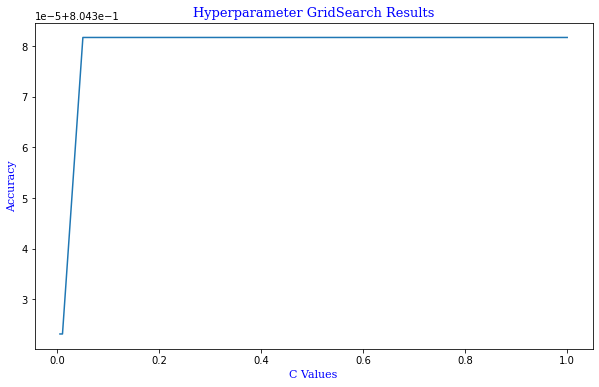

In [18]:
#initially using a large range of c values with high distribution

c = [0.005, 0.01, 0.05, 0.1, 0.5, 1]

lr_gridsearch(X_train_a, y_train_a, c)

Exploring the ***C*** values around 0.05 by creating a range of c values from 0.001 to 0.07

Tuned hyperparameter is at {'C': 0.017} with accuracy : 0.8043816906811315


,params,mean_test_score
0,{'C': 0.001},0.803914
1,{'C': 0.003},0.804060
2,{'C': 0.005},0.804323
3,{'C': 0.007},0.804323
4,{'C': 0.009000000000000001},0.804323
5,{'C': 0.011},0.804323
6,{'C': 0.013000000000000001},0.804323
7,{'C': 0.015},0.804323
8,{'C': 0.017},0.804382
9,{'C': 0.019000000000000003},0.804382


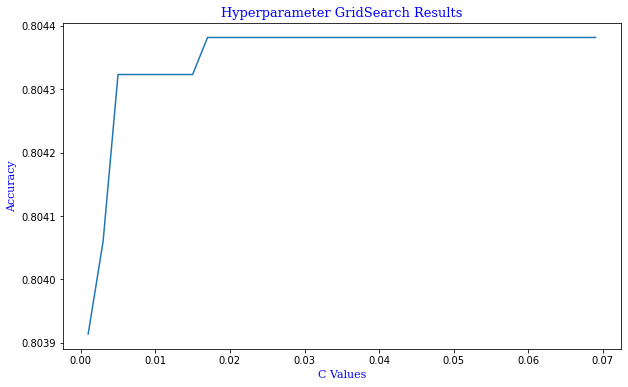

In [19]:
#tuning into a more concentrated range of c

a =  np.arange(0.001, 0.07, 0.002)

lr_gridsearch(X_train_a, y_train_a, a)


**Adult Dataset:** The hyperparameter for the highest accuracy (**0.8043816906811315**) is at **C: 0.017**



### German


Tuned hyperparameter is at {'C': 0.01} with accuracy : 0.7185714285714286


,params,mean_test_score
0,{'C': 0.005},0.715714
1,{'C': 0.01},0.718571
2,{'C': 0.05},0.715714
3,{'C': 0.1},0.715714
4,{'C': 0.5},0.715714
5,{'C': 1},0.715714


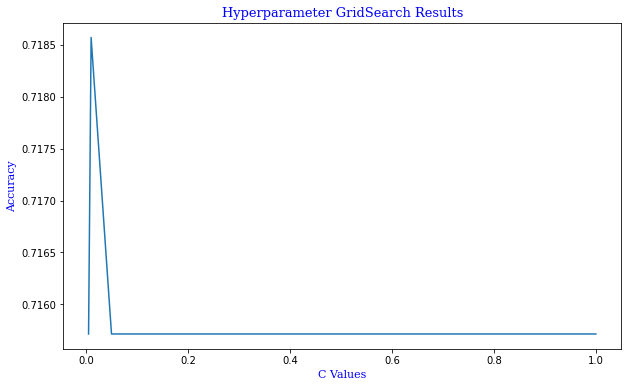

In [20]:
#initially using a large range of c values with high distribution

lr_gridsearch(X_train_g, y_train_g, c)

Exploring the ***C*** values around 0.01 by creating a range of c values from 0.001 to 0.03

Tuned hyperparameter is at {'C': 0.009000000000000001} with accuracy : 0.7185714285714286


,params,mean_test_score
0,{'C': 0.001},0.701429
1,{'C': 0.002},0.708571
2,{'C': 0.003},0.717143
3,{'C': 0.004},0.714286
4,{'C': 0.005},0.715714
5,{'C': 0.006},0.717143
6,{'C': 0.007},0.717143
7,{'C': 0.008},0.717143
8,{'C': 0.009000000000000001},0.718571
9,{'C': 0.010000000000000002},0.718571


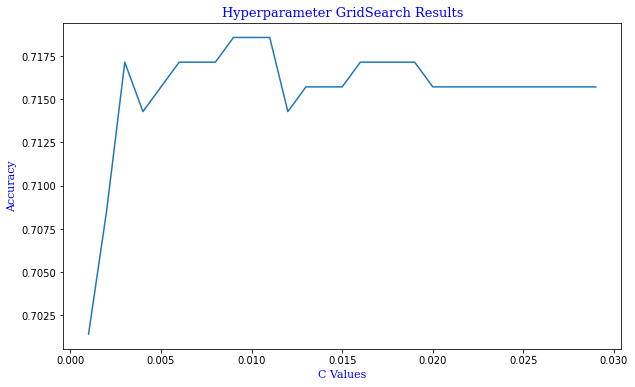

In [21]:
b =  np.arange(0.001, 0.03, 0.001)

lr_gridsearch(X_train_g, y_train_g, b)

**German Dataset:** The hyperparameter for the highest accuracy (**0.7185714285714286**) is at **C: 0.009**


## (2) Equality of Opportunity Fairness Metrics

Adding Equality of Opportunity into our function, combing accuracy and Equality of Opportunity

The fairness metric we use is the Equality of Opportunity 
- Equality of Opportunity: True Negative Rate (TNR) or True Positive Rate (TPR) should be equal for all groups


Ideally we want to satisy all fairness definitions but this is only possible under trivial circumstances.

### Functions

In [22]:
#function to evaluate the accuracy and the fairness of each hyperparameter and report the best

def cv_accuracy_fairness(X_train, y_train, train, cvals):
  c_values = cvals
  #empty lists
  acc_scores = []
  equ_opp = []
  avg_acc_scores = []

  #a loop to evaluate each hyperparameter under 5-fold cross validation
  for i in c_values:
    #training the model
    clf = LogisticRegression(solver='liblinear', C=i, random_state=1)
    #using cross val score to find the accuracy, can be used instead of gridsearch
    score = cross_val_score(clf, X_train, y_train, cv = 5)
    #using cross val predict to generate cross-validated estimates for each input data point 
    y_fair = cross_val_predict(clf, X_train, y_train, cv = 5)
    test_pred = train.copy()
    test_pred.labels = y_fair
    metric = ClassificationMetric(train, test_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
    equ_opp.append(metric.equal_opportunity_difference())

    #print(equ_opp)
    avg_acc = np.mean(score)
    avg_acc_scores.append(np.mean(score))
  
  #printing the best of the equal opportunity scores
  equal_opp_best = min(equ_opp, key= abs)
  #for the best c value
  best_c = equ_opp.index(equal_opp_best)
  #best average score
  #this should be the same as the grid search
  best_acc_c = avg_acc_scores.index(max(avg_acc_scores))

  #printing off the results and corresponding c value
  print('Best Equality of Opportunity score is at C: ', c_values[best_c], 'with Equality of Opportunity score of', equal_opp_best)
  print('Best accuracy score is at C: ', c_values[best_acc_c], 'with accuracy score of', max(avg_acc_scores))

  #creating a df to show the values
  df = pd.DataFrame({'C': c_values, 
                  'Accuracy' :avg_acc_scores,
                  'Equality of Opportunity': equ_opp})
  
  #plotting the results 
  xplt = np.array(cvals)
  plt.figure(figsize = (10,6))
  plt.plot(xplt, df['Equality of Opportunity'], color = 'green')
  font1 = {'family':'serif','color':'green','size':13}
  font2 = {'family':'serif','color':'green','size':11}
  plt.title('Equality of Opportunity Hyperparameter Tuning', fontdict = font1)
  plt.xlabel('C Value', fontdict = font2)
  plt.ylabel('Equality of Opportunity', fontdict = font2)
  plt.show()
  return df


### Adult


Best Equality of Opportunity score is at C:  0.001 with Equality of Opportunity score of -0.4464800923254472
Best accuracy score is at C:  0.017 with accuracy score of 0.8043816906811315


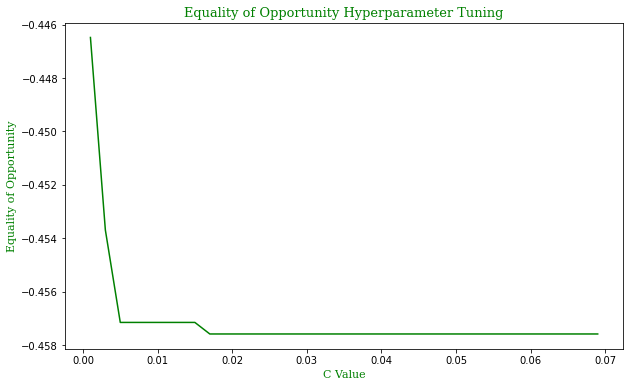

In [23]:
dfa = cv_accuracy_fairness(X_train_a, y_train_a, a_train, a)

In [24]:
#highlighting the best c value

def yellow(s):
  if s['C'] == 0.001:
    return ['background-color: lightgreen']*3

dfa.style.apply(yellow, axis=1)

,C,Accuracy,Equality of Opportunity
0,0.001000,0.803914,-0.446480
1,0.003000,0.804060,-0.453693
2,0.005000,0.804323,-0.457155
3,0.007000,0.804323,-0.457155
4,0.009000,0.804323,-0.457155
5,0.011000,0.804323,-0.457155
6,0.013000,0.804323,-0.457155
7,0.015000,0.804323,-0.457155
8,0.017000,0.804382,-0.457588
9,0.019000,0.804382,-0.457588


Refining the C values

Best Equality of Opportunity score is at C:  0.001 with Equality of Opportunity score of -0.4464800923254472
Best accuracy score is at C:  0.004 with accuracy score of 0.8043231940446883


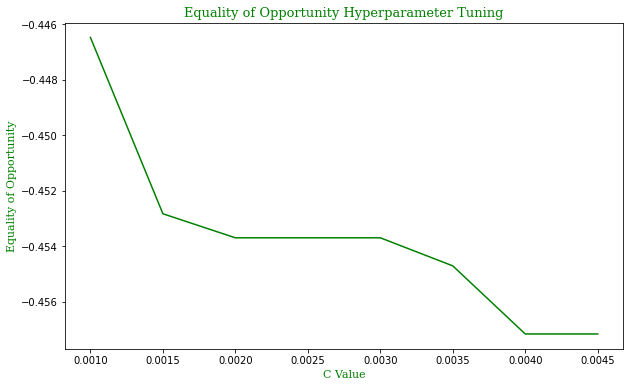

In [25]:
#narrowing in and expanding the c values

dfa2 = cv_accuracy_fairness(X_train_a, y_train_a, a_train, np.arange(0.001, 0.005, 0.0005))

**Adult Dataset:** The hyperparameter for the best *Equality of Opportunity* is at **C: 0.001** with a score of **-0.44648009**

### German


Best Equality of Opportunity score is at C:  0.051000000000000004 with Equality of Opportunity score of -0.050097847358121395
Best accuracy score is at C:  0.009000000000000001 with accuracy score of 0.7185714285714286


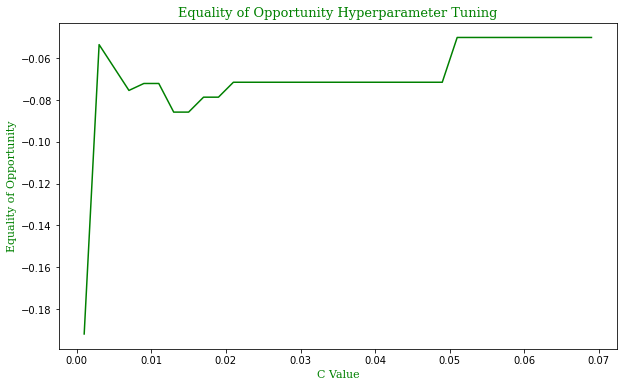

In [26]:
#for german

dfg = cv_accuracy_fairness(X_train_g, y_train_g, g_train, a)

**German Dataset:** The hyperparameter for the best *Equality of Opportunity* is at **C: 0.051** with a score of **-0.050097847358121395**



In [27]:
#highlighting the best c value for fairness
def syling(s):
  if s['C'] == 0.051000000000000004:
    return ['background-color: lightgreen']*3
  else:
    return ['background-color: white']*3

dfg.style.apply(syling, axis = 1)


,C,Accuracy,Equality of Opportunity
0,0.001000,0.701429,-0.191977
1,0.003000,0.717143,-0.053523
2,0.005000,0.715714,-0.064481
3,0.007000,0.717143,-0.075440
4,0.009000,0.718571,-0.072114
5,0.011000,0.718571,-0.072114
6,0.013000,0.715714,-0.085812
7,0.015000,0.715714,-0.085812
8,0.017000,0.717143,-0.078669
9,0.019000,0.717143,-0.078669


## Compute and Report Final Accuracy and Fairness Metric


### Task 1: Table of Results from Training Data

| Dataset | C Value for Highest Accuracy (1) | C Value for Best Fairness Metrics (2) |
| --- | :---: | ---: |
| **Adult** | 0.017 | 0.001 |
| **German** | 0.009 | 0.051 |

### Functions

In [28]:
#function for final scores

def finalscores(X_train, y_train, X_test, y_test, test, c):

  #empty lists
  equ_opp_list = []
  acc = []
  disparate = []

  #tarining the log red model
  clf = LogisticRegression(solver='liblinear', C=c, random_state=1)
  #fitting to the train values
  clf.fit(X_train,y_train)
  #predicting on the test set
  y_pred = clf.predict(X_test)
  test_pred = test.copy()
  test_pred.labels = y_pred
  
  #appending the lists with accuracy scores
  acc.append(sum(y_pred==y_test)/len(y_test))

  #classifcation metric
  metric = ClassificationMetric(test, test_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
  #appending the lists with equ of opp and disparate impact
  equ_opp_list.append(metric.equal_opportunity_difference()) #would like it to be close to 0
  disparate.append(metric.disparate_impact()) #value close to 0 indicates strong bias

  print('The final Accuracy score on the test data with hyperparameter C:', c, 'is', clf.score(X_test, y_test))
  print('The final Equality of Opportunity score at C:', c, 'is', equ_opp_list)
  print('The disparate impact score is', disparate)
  

### Adult


**Adult Dataset:** 

<font color='blue'>**(1)**</font> The hyperparameter for the highest accuracy on training data is at **C: 0.017**




In [29]:
#final scores for the adult test set, with hyperparameter 0.17

finalscores(X_train_a, y_train_a, X_test_a, y_test_a, a_test, 0.017)

The final Accuracy score on the test data with hyperparameter C: 0.017 is 0.8039991810550741
The final Equality of Opportunity score at C: 0.017 is [-0.4581379772270596]
The disparate impact score is [0.0]


> The <font color='blue'>**final *accuracy* score**</font> in testing data at hyperparameter C: 0.017 is <font color='blue'>**0.804**</font>

<font color='green'>**(2)**</font> The hyperparameter for the best fairness metric on training data is at **C: 0.001**

In [30]:
#final scores for the adult test set, with hyperparameter 0.001

finalscores(X_train_a, y_train_a, X_test_a, y_test_a, a_test, 0.001)

The final Accuracy score on the test data with hyperparameter C: 0.001 is 0.8042721626970586
The final Equality of Opportunity score at C: 0.001 is [-0.4511051574012056]
The disparate impact score is [0.0]


> The <font color='green'>**final *Equality of Opportunity* score**</font> in testing data at hyperparameter C: 0.001 is <font color='green'>**-0.45110**</font>


### German

**German Dataset:** 

<font color='blue'>**(1)**</font>  The hyperparameter for the highest accuracy on training data is at **C: 0.009**




In [31]:
#final scores for the german test set, with hyperparameter 0.009

finalscores(X_train_g, y_train_g, X_test_g, y_test_g, g_test, 0.009)

The final Accuracy score on the test data with hyperparameter C: 0.009 is 0.6466666666666666
The final Equality of Opportunity score at C: 0.009 is [-0.1504771225838023]
The disparate impact score is [0.7754407051282051]


> The <font color='blue'>**final *accuracy* score**</font> in testing data at hyperparameter C: 0.009 is <font color='blue'>**0.6467**</font>

<font color='green'>**(2)**</font> The hyperparameter for best fairness metricon training data is at **C: 0.051**

In [32]:
#final scores for the german test set, with hyperparameter 0.051

finalscores(X_train_g, y_train_g, X_test_g, y_test_g, g_test, 0.051)

The final Accuracy score on the test data with hyperparameter C: 0.051 is 0.6466666666666666
The final Equality of Opportunity score at C: 0.051 is [-0.1504771225838023]
The disparate impact score is [0.7754407051282051]



> The <font color='green'>**final *Equality of Opportunity* score**</font> on testing data at hyperparameter C: 0.051 is <font color='green'>**-0.1505**</font>


___

# **Task 2** 

Now choose an algorithmic fairness method, e.g. reweighing (Lecture 7), and perform
the same analysis, i.e. how varying the hyperparameter(s) impacts accuracy and fairness metrics
during model selection.
Specifically, using the same 5-fold cross validation as in Task 1, perform validation by varying
the trade-off hyperparameter and select (3) the model with the highest accuracy, and (4) the
model with the best fairness metric across 5 folds. After model selection, compute and report
final accuracy and fairness for both models (3) and (4) on the test set.

## (3) Hyperparameter tuning using GridSearch: Re-weighing 

### Functions

In [33]:
#reweighing gridsearch function

def rw_gridsearch (X, y, train,cvals):
  #mitgating the bias
  #assigning the new weights to the unprivileged and privileged groups, transform the dataset with reweighing
  RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
  #obtaining a set of weights for the training set
  train = RW.fit_transform(train)
  #training the model and using gridsearch, 5-fold cross validation
  clf= GridSearchCV(LogisticRegression(solver = 'liblinear', random_state = 1), {'C':cvals}, cv=5)
  #fitting to new weights
  clf.fit(X,y,sample_weight=train.instance_weights)

  #displaying the results
  clf.cv_results_
  print('Tuned hyperparameters : ',clf.best_params_, 'with accuracy of', clf.best_score_)

  #showing the dataframe
  df = pd.DataFrame(clf.cv_results_)
  display(df[['params','mean_test_score' ]])

  #plotting the results
  xplt = np.array(cvals)
  plt.figure(figsize = (10,6))
  plt.plot(xplt, df['mean_test_score' ], color = 'purple')
  font1 = {'family':'serif','color':'purple','size':13}
  font2 = {'family':'serif','color':'purple','size':11}
  plt.title('C Value vs Average', fontdict = font1)
  plt.xlabel('C Value', fontdict = font2)
  plt.ylabel('Average', fontdict = font2)
  plt.show()

### Adult

Tuned hyperparameters :  {'C': 0.05} with accuracy of 0.7884409465674679


,params,mean_test_score
0,{'C': 0.005},0.788382
1,{'C': 0.01},0.787944
2,{'C': 0.05},0.788441
3,{'C': 0.1},0.788441
4,{'C': 0.5},0.788441
5,{'C': 1},0.788441


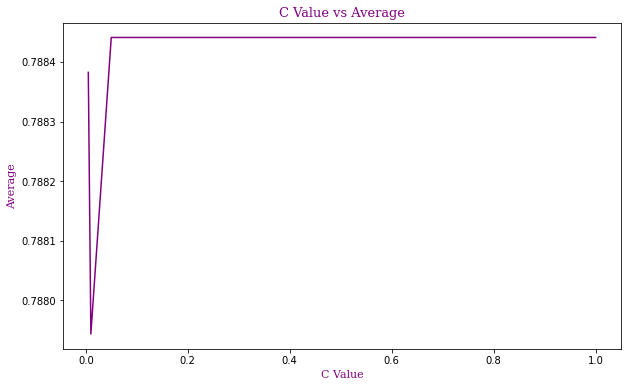

In [34]:
#reweigh the adult dataset and perfrom gridsearch
#on a broad range of c

rw_gridsearch (X_train_a, y_train_a, a_train, c)

Tuned hyperparameters :  {'C': 0.001} with accuracy of 0.7891137006660291


,params,mean_test_score
0,{'C': 0.001},0.789114
1,{'C': 0.003},0.788704
2,{'C': 0.005},0.788382
3,{'C': 0.007},0.788382
4,{'C': 0.009000000000000001},0.787944
5,{'C': 0.011},0.788002
6,{'C': 0.013000000000000001},0.788002
7,{'C': 0.015},0.788441
8,{'C': 0.017},0.788441
9,{'C': 0.019000000000000003},0.788441


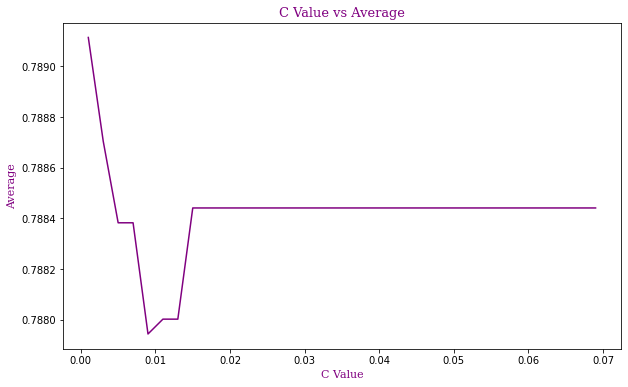

In [35]:
#refining into c more

rw_gridsearch(X_train_a, y_train_a, a_train, np.arange(0.001, 0.07, 0.002))

**Adult Dataset:** The hyperparameter for the highest accuracy (**0.7891**) is at **C: 0.001**


### German

Tuned hyperparameters :  {'C': 0.5} with accuracy of 0.7128571428571429


,params,mean_test_score
0,{'C': 0.005},0.711429
1,{'C': 0.01},0.705714
2,{'C': 0.05},0.708571
3,{'C': 0.1},0.710000
4,{'C': 0.5},0.712857
5,{'C': 1},0.712857


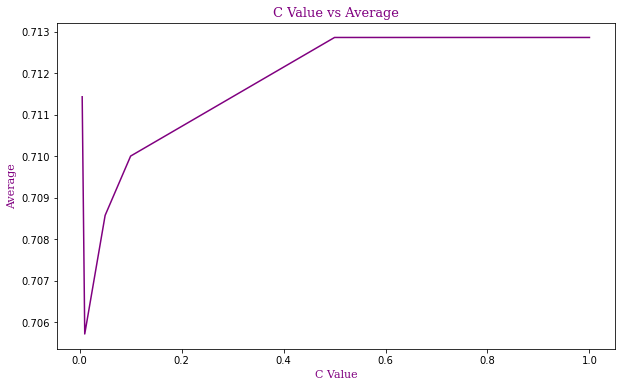

In [36]:
#reweigh the german dataset and perfrom gridsearch
#on a broad range of c

rw_gridsearch (X_train_g, y_train_g, g_train, c)

Expanding the C values

Tuned hyperparameters :  {'C': 0.10999999999999997} with accuracy of 0.7128571428571429


,params,mean_test_score
0,{'C': 0.01},0.705714
1,{'C': 0.015},0.710000
2,{'C': 0.019999999999999997},0.710000
3,{'C': 0.024999999999999998},0.707143
4,{'C': 0.03},0.704286
...,...,...
193,{'C': 0.9749999999999999},0.712857
194,{'C': 0.9799999999999999},0.712857
195,{'C': 0.9849999999999999},0.712857
196,{'C': 0.9899999999999999},0.712857


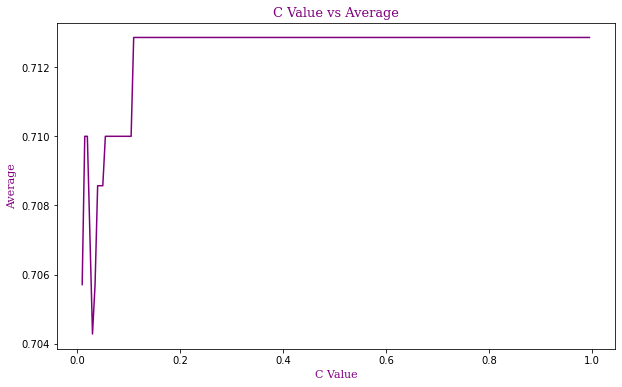

In [37]:
#refining into c more

rw_gridsearch (X_train_g, y_train_g, g_train, np.arange(0.01, 1, 0.005))

**German Dataset:** The hyperparameter for the highest accuracy (**0.7129**) is at **C: 0.12**

## (4) Equality of Opportunity Fairness Metrics: Re-weighing 

### Functions

In [38]:
def cv_rw_fairness(X_train, y_train, train, cval):
  c_values = cval
  #empty lists
  acc_scores = []
  fairness = []
  equ_opp = []
  avg_acc_scores = []

  #mitgating the bias
  #assigning the new weights to the unprivileged and privileged groups, transform the dataset with reweighing
  RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
  #obtaining a set of weights for the training set
  train = RW.fit_transform(train)

  
  for i in c_values:
    clf = LogisticRegression(solver = 'liblinear', C=i, random_state = 1)

    #accuracy score with cross val score
    #as reweighed, set params to 'sample weight': train.instance_weights
    score = cross_val_score(clf, X_train, y_train, cv = 5, fit_params={'sample_weight': train.instance_weights}) #cv = 5 means 5 fold cross validation
    #fairness predictions with cross val predict
    #generates cross-validated estimates for each input data point
    fairness = cross_val_predict(clf, X_train, y_train, cv = 5, fit_params={'sample_weight': train.instance_weights}) #cv = 5 means 5 fold cross validation
    test_pred = train.copy()
    #get the fair prediction labels
    test_pred.labels = fairness

    #defining our metric
    metric = ClassificationMetric(train, test_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

    #equality of opportunity score
    equ_opp.append(metric.equal_opportunity_difference())

    #average score
    avg_acc = np.mean(score)
    avg_acc_scores.append(np.mean(score))

  
  #defining the best 
  equal_opp_best = min(equ_opp, key= abs)
  best_c = equ_opp.index(equal_opp_best)

  #best average score
  best_acc_c = avg_acc_scores.index(max(avg_acc_scores))
  
  #reporting the results with the best c value
  print('Best accuracy score is at C: ', c_values[best_acc_c], 'with accuracy score of', max(avg_acc_scores))
  print('Best Equality of Opportunity score is at C:',c_values[best_c],  'with score' ,equal_opp_best)

  #reporting the results in a dataframe
  df = pd.DataFrame({'C': c_values, 
                  'Accuracy' :avg_acc_scores,
                  'Equality of Opportunity': equ_opp})
  
  #plotting results
  xplt = np.array(cval)
  plt.figure(figsize = (10,6))
  plt.plot(xplt, df['Equality of Opportunity'], color = 'darkorange')
  font1 = {'family':'serif','color':'darkorange','size':13}
  font2 = {'family':'serif','color':'darkorange','size':11}
  plt.title('Reweighing: Equality of Opportunity Hyperparameter tuning', fontdict = font1)
  plt.xlabel('C Value', fontdict = font2)
  plt.ylabel('Equality of Opportunity', fontdict = font2)
  plt.show()
  return(df)




### Adult

Best accuracy score is at C:  0.001 with accuracy score of 0.7891137006660291
Best Equality of Opportunity score is at C: 0.003 with score -0.008177456922513315


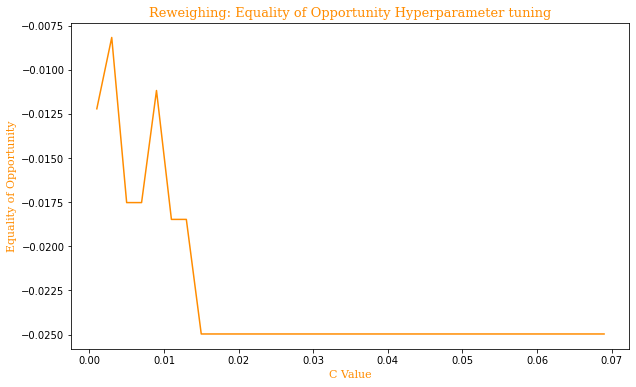

In [39]:
#reweighted cross fold on adults dataset with refined c

dfa3 = cv_rw_fairness(X_train_a, y_train_a, a_train, a)

**Adult Dataset:** (Re-weighing) The hyperparameter for the best *Equality of Opportunity* is at **C: 0.003** with a score of **-0.008017**

In [40]:
def syling(s):
  if s['C'] == 0.003:
    return ['background-color: orange']*3
  else:
    return ['background-color: white']*3

dfa3.style.apply(syling, axis = 1)

,C,Accuracy,Equality of Opportunity
0,0.001000,0.789114,-0.012217
1,0.003000,0.788704,-0.008177
2,0.005000,0.788382,-0.017528
3,0.007000,0.788382,-0.017528
4,0.009000,0.787944,-0.011181
5,0.011000,0.788002,-0.018480
6,0.013000,0.788002,-0.018480
7,0.015000,0.788441,-0.024968
8,0.017000,0.788441,-0.024968
9,0.019000,0.788441,-0.024968


### German

Best accuracy score is at C:  0.001 with accuracy score of 0.72
Best Equality of Opportunity score is at C: 0.027000000000000003 with score -0.000684931506849451


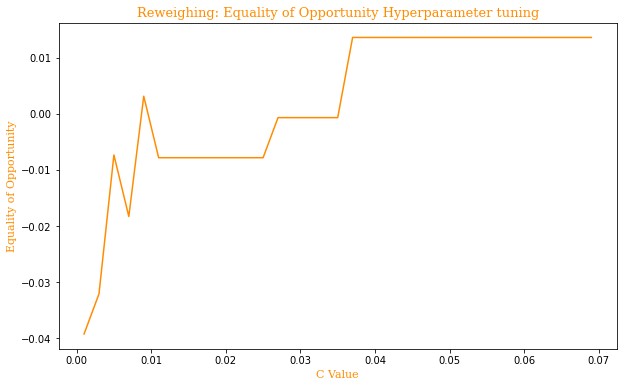

In [41]:
#reweighted cross fold on german dataset with refined c

dfg3 = cv_rw_fairness(X_train_g, y_train_g, g_train, a)

**German Dataset:** (Re-weighing) The hyperparameter for *Equality of Opportunity* is at **C: 0.027** with a score of **-0.0006849**


In [42]:
def syling(s):
  if s['C'] == 0.027000000000000003:
    return ['background-color: orange']*3
  else:
    return ['background-color: white']*3

dfg3.style.apply(syling, axis = 1)

,C,Accuracy,Equality of Opportunity
0,0.001000,0.720000,-0.039237
1,0.003000,0.718571,-0.032094
2,0.005000,0.711429,-0.007339
3,0.007000,0.710000,-0.018297
4,0.009000,0.705714,0.003131
5,0.011000,0.710000,-0.007828
6,0.013000,0.710000,-0.007828
7,0.015000,0.710000,-0.007828
8,0.017000,0.710000,-0.007828
9,0.019000,0.710000,-0.007828


## Compute and Report the Final Accuracy: Re-weighing


### Task 2: Table of Results from Training Data

| Dataset | C Value for Highest Accuracy (3) | C Value for Best Fairness Metrics (4) |
| --- | :---: | ---: |
| **Adult** | 0.001 | 0.003 |
| **German** | 0.12 | 0.027 |

### Functions

In [43]:
#reweighing final scores

def rw_finalscores(X_train, y_train, X_test, y_test,train, test, c):
  equ_opp_list = []
  acc = []
  disparate = []
  #mitgating the bias
  #assigning the new weights to the unprivileged and privileged groups, transform the dataset with reweighing
  RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
  #obtaining a set of weights for the training set
  train = RW.fit_transform(train)
  clf = LogisticRegression(solver='liblinear', C=c, random_state=1)
  clf.fit(X_train,y_train,sample_weight=train.instance_weights)
  y_pred = clf.predict(X_test)
  test_pred = test.copy()
  test_pred.labels = y_pred
  metric = ClassificationMetric(test, test_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
  
  #storing the results
  acc.append(sum(y_pred==y_test)/len(y_test))
  equ_opp_list.append(metric.equal_opportunity_difference()) #would like it to be close to 0
  disparate.append(metric.disparate_impact()) #value close to 0 indicates strong bias, would like to be close to 1

  #printing the results
  print('After reweighing, the final accuracy score on the test data with hyperparameter C:', c, 'is', clf.score(X_test, y_test))
  print('The Equality of Opportunity score at C:', c, 'is', equ_opp_list)
  print('The disparate impact score is', disparate)


### Adult

<font color='purple'>**(3)**</font> The hyperparameter for the highest accuracy on training data is at **C: 0.001**



In [44]:
#adult final scores at hyperparameter 0.001

rw_finalscores(X_train_a, y_train_a, X_test_a, y_test_a,a_train, a_test, 0.001)

After reweighing, the final accuracy score on the test data with hyperparameter C: 0.001 is 0.7919197433972566
The Equality of Opportunity score at C: 0.001 is [0.03607506672931393]
The disparate impact score is [0.7025889736823336]


> After reweighing, the <font color='purple'>**final *accuracy* score**</font> in testing data at hyperparameter C: 0.001 is <font color='purple'>**0.79192**</font>

<font color='darkorange'>**(4)**</font> The hyperparameter for the best Equality of Opportunity score on training data is at **C: 0.003**

In [45]:
#adult final scores at hyperparameter 0.003

rw_finalscores(X_train_a, y_train_a, X_test_a, y_test_a,a_train, a_test, 0.003)

After reweighing, the final accuracy score on the test data with hyperparameter C: 0.003 is 0.7904183443663414
The Equality of Opportunity score at C: 0.003 is [0.050140706381021916]
The disparate impact score is [0.7250312798999043]


> After reweighing, the <font color='orange'>**final *Equality of Opportunity* score**</font> on testing data at hyperparameter C: 0.003 is <font color='orange'>**0.05014**</font>

### German

<font color='purple'>**(3)**</font> The hyperparameter for the highest accuracy on training data is at **C: 0.12**



In [46]:
#german final scores at hyperparameter 0.012

rw_finalscores(X_train_g, y_train_g, X_test_g, y_test_g,g_train, g_test, 0.12)

After reweighing, the final accuracy score on the test data with hyperparameter C: 0.12 is 0.6366666666666667
The Equality of Opportunity score at C: 0.12 is [-0.002936138977244984]
The disparate impact score is [0.9815705128205129]


> After reweighing, the <font color='purple'>**final *accuracy* score**</font> in testing data at hyperparameter C: 0.12 is <font color='purple'>**0.6566**</font>

<font color='darkorange'>**(4)**</font> The hyperparameter for the best Equality of Opportunity score on training data is at **C: 0.027**

In [47]:
#german final scores at hyperparameter 0.027

rw_finalscores(X_train_g, y_train_g, X_test_g, y_test_g,g_train, g_test, 0.027)

After reweighing, the final accuracy score on the test data with hyperparameter C: 0.027 is 0.6366666666666667
The Equality of Opportunity score at C: 0.027 is [-0.002936138977244984]
The disparate impact score is [0.9815705128205129]


> After reweighing, the <font color='orange'>**final *Equality of Opportunity* score**</font> on testing data at hyperparameter C: 0.027 is <font color='orange'>**-0.0029**</font>

---

# **Task 3a (Extra)**

Based on your observations, suggest a model selection strategy (criterion)
that accounts for both, accuracy and fairness. Compare the standard machine learning model
versus the fairness-based machine learning model using the proposed criterion - what is the effect
(if any)?
Specifically, using the same 5-fold cross validation as before, select (5) the standard machine
learning model (studied in Task 1), and (6) the fairness-based model (studied in Task 2) based
on the proposed accuracy+fairness criterion. After model selection, compute and report final
accuracy and fairness for both models (5) and (6) on the test set.

What will I be looking at?

For part (a) I shall be observing the combination of accuracy and fairness and comparing this with a standard machine learning model and a fairness based machine learning model. 

## (5a) Standard Machine Learning Model

### Functions

In [48]:
#need to find a sweetspot between the fairness and accuracy
#we want high accuracy and low equal opp 
#we would then want high 1-(low equal opp)
#add (accuracy and high 1-(low equal opp)) - 1 would be the best combined score

#looking into the f1 score 

def fairaccuracyf1(X_train, y_train, train, cvals):
  #empty lists for our scores
  acc_scores = []
  fairness = []
  equ_opp = []
  avg_acc_scores = []
  f1score = []

#looping through each C value
  for i in cvals:
    #our model
    clf = LogisticRegression(solver='liblinear', C=i, random_state=1)
    #accuracy score
    score = cross_val_score(clf, X_train, y_train, cv = 5)
    #prediction labels for fairness
    fair_pred = cross_val_predict(clf, X_train, y_train, cv = 5)
    test_pred = train.copy()
    test_pred.labels = fair_pred

    #defining our metric
    metric = ClassificationMetric(train, test_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

    #recording the scores
    equ_opp.append(metric.equal_opportunity_difference())
    f1score.append(f1_score(y_train, fair_pred, average = 'macro'))
    avg_acc = np.mean(score)
    avg_acc_scores.append(np.mean(score))

  #taking the absolute value for the Equality of Opportunity scores
  absol_equ_opp = []
  for value in equ_opp:
    absolute = abs(value)
    absol_equ_opp.append(absolute)

  #combining the values of accuracy and Equality of Opportunity
  combined = [i + (1-j) for (i, j) in zip(avg_acc_scores , absol_equ_opp)]


  #re-scaling the combined value to be out of 1, closer to 1 is better
  rescaledcombined = []
  for value in combined:
    rescaled = value - 1
    rescaledcombined.append(rescaled)
  
  #the best scores
  best_c = equ_opp.index(min(equ_opp, key= abs))
  best_acc_c = avg_acc_scores.index(max(avg_acc_scores)) # we want this to be close to 1
  best_combined = rescaledcombined.index(max(rescaledcombined)) # we want this to be close to 1
  best_f1 = f1score.index(max(f1score)) #we want f1 score to be 1

  print('Best accuracy score is at C: ', cvals[best_acc_c], 'with accuracy score of', max(avg_acc_scores))
  print('Best Equality of Opportunity score is at C: ', cvals[best_c], 'with an equality of opportunity score of', min(equ_opp, key= abs))
  print('Best f1 score is at C: ', cvals[best_f1], 'with a score of', max(f1score))
  print('Best combined score is at C: ', cvals[best_combined], 'with a score of', max(rescaledcombined))
  

  #plotting the results
  xplt = cvals
  plt.figure(figsize = (10,6))
  plt.scatter(xplt, rescaledcombined, color = 'darkviolet', label = 'Combined: Average and Equality of Opportunity')
  plt.scatter(xplt, f1score, color = 'red', label = 'F1 Score')
  plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.10),
          fancybox=True, shadow=True)

  font1 = {'family':'serif','color':'darkviolet','size':13}
  font2 = {'family':'serif','color':'darkviolet','size':11}
  plt.title('Sweet Spot', fontdict = font1, color = 'darkviolet')
  plt.xlabel('C Value', fontdict = font2)
  plt.ylabel('Score', fontdict = font2)
  plt.show()
  

  #return(df) 

### Adult

Best accuracy score is at C:  0.05 with accuracy score of 0.8043816906811315
Best Equality of Opportunity score is at C:  0.005 with an equality of opportunity score of -0.45715522215810733
Best f1 score is at C:  0.05 with a score of 0.6829809555455333
Best combined score is at C:  0.005 with a score of 0.347167971886581


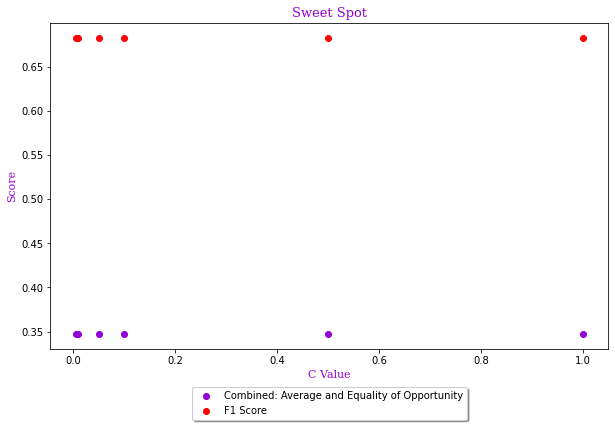

In [49]:
#plotting results for a broud c

fairaccuracyf1(X_train_a, y_train_a, a_train, c)

Exploring around 0.05

Best accuracy score is at C:  0.021 with accuracy score of 0.8043816906811315
Best Equality of Opportunity score is at C:  0.001 with an equality of opportunity score of -0.4464800923254472
Best f1 score is at C:  0.021 with a score of 0.6829809555455333
Best combined score is at C:  0.001 with a score of 0.3574336252641368


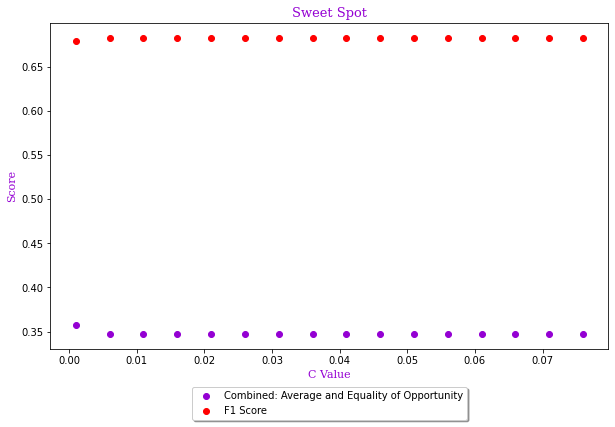

In [50]:
#plotting results for a more refined c

fairaccuracyf1(X_train_a, y_train_a, a_train, np.arange(0.001, 0.08, 0.005))

Exploring around 0.021

Best accuracy score is at C:  0.016999999999999994 with accuracy score of 0.8043816906811315
Best Equality of Opportunity score is at C:  0.01 with an equality of opportunity score of -0.45715522215810733
Best f1 score is at C:  0.016999999999999994 with a score of 0.6829809555455333
Best combined score is at C:  0.01 with a score of 0.347167971886581


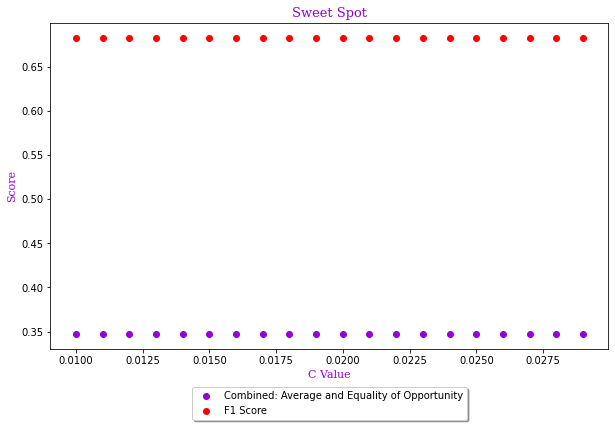

In [51]:
#plotting results for a more refined c

fairaccuracyf1(X_train_a, y_train_a, a_train, np.arange(0.01, 0.03, 0.001))

### German

Best accuracy score is at C:  0.01 with accuracy score of 0.7185714285714286
Best Equality of Opportunity score is at C:  0.05 with an equality of opportunity score of -0.050097847358121395
Best f1 score is at C:  0.005 with a score of 0.5569887959190813
Best combined score is at C:  0.05 with a score of 0.6656164383561642


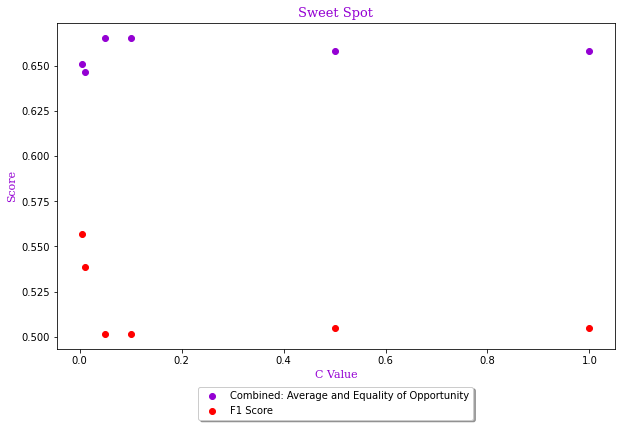

In [52]:
#plotting results for a broud c

fairaccuracyf1(X_train_g, y_train_g, g_train, c)

Best accuracy score is at C:  0.009000000000000001 with accuracy score of 0.7185714285714286
Best Equality of Opportunity score is at C:  0.05 with an equality of opportunity score of -0.050097847358121395
Best f1 score is at C:  0.001 with a score of 0.5719406041986688
Best combined score is at C:  0.05 with a score of 0.6656164383561642


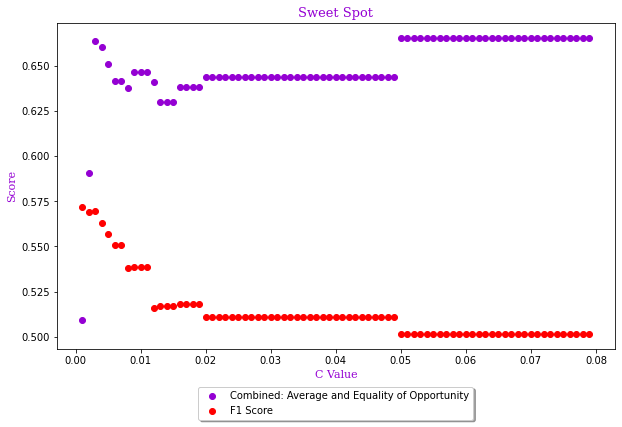

In [53]:
#plotting results for a more refined c around 0.005

fairaccuracyf1(X_train_g, y_train_g, g_train,  np.arange(0.001, 0.08, 0.001))

Best accuracy score is at C:  0.008199999999999999 with accuracy score of 0.7185714285714286
Best Equality of Opportunity score is at C:  0.0028 with an equality of opportunity score of -0.05352250489236787
Best f1 score is at C:  0.001 with a score of 0.5719406041986688
Best combined score is at C:  0.0028 with a score of 0.6636203522504893


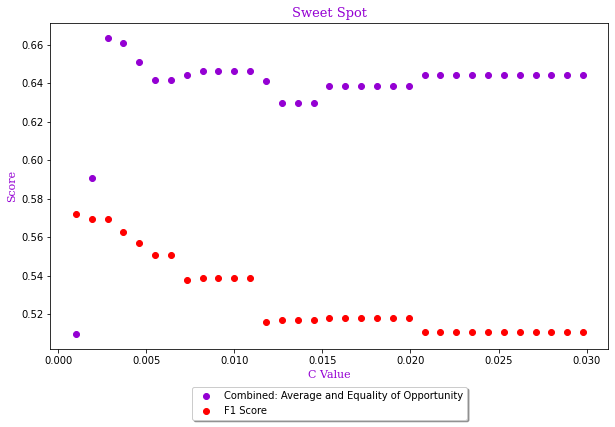

In [54]:
#plotting results for a more refined c around 0.005

fairaccuracyf1(X_train_g, y_train_g, g_train,  np.arange(0.001, 0.03, 0.0009))

Best accuracy score is at C:  0.011 with accuracy score of 0.7185714285714286
Best Equality of Opportunity score is at C:  0.051000000000000004 with an equality of opportunity score of -0.050097847358121395
Best f1 score is at C:  0.001 with a score of 0.5719406041986688
Best combined score is at C:  0.051000000000000004 with a score of 0.6656164383561642


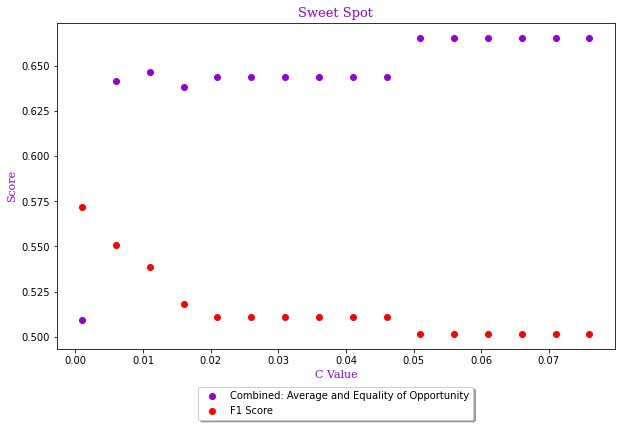

In [55]:
#plotting results for a more refined c around 0.0028

fairaccuracyf1(X_train_g, y_train_g, g_train,  np.arange(0.001, 0.08, 0.005))

## (6a) Fairness-based Machine Learning Model

### Functions

In [56]:
#need to find a sweetspot between the fairness and accuracy
#we want high accuracy and low equal opp 
#we would then want high 1-(low equal opp)
#add (accuracy and high 1-(low equal opp)) - 1 would be the best combined score

#looking into the f1 score 

def rw_fairaccuracyf1(X_train, y_train, train, cvals):
  #empty lists for our scores
  acc_scores = []
  fairness = []
  equ_opp = []
  avg_acc_scores = []
  f1score = []
  #mitgating the bias
  #assigning the new weights to the unprivileged and privileged groups, transform the dataset with reweighing
  RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
  #obtaining a set of weights for the training set
  train = RW.fit_transform(train)


#looping through each C value
  for i in cvals:
    #our model
    clf = LogisticRegression(solver='liblinear', C=i, random_state=1)
    #accuracy score
    score = cross_val_score(clf, X_train, y_train, fit_params={'sample_weight': train.instance_weights}, cv = 5)
    #prediction labels for fairness
    fair_pred = cross_val_predict(clf, X_train, y_train, fit_params={'sample_weight': train.instance_weights}, cv = 5)
    test_pred = train.copy()
    test_pred.labels = fair_pred

    #defining our metric
    metric = ClassificationMetric(train, test_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

    #recording the scores
    equ_opp.append(metric.equal_opportunity_difference())
    f1score.append(f1_score(y_train, fair_pred, average = 'macro'))
    avg_acc = np.mean(score)
    avg_acc_scores.append(np.mean(score))

  #taking the absolute value for the Equality of Opportunity scores
  absol_equ_opp = []
  for value in equ_opp:
    absolute = abs(value)
    absol_equ_opp.append(absolute)

  #combining the values of accuracy and Equality of Opportunity
  combined = [i + (1-j) for (i, j) in zip(avg_acc_scores , absol_equ_opp)]


  #re-scaling the combined value to be out of 1, closer to 1 is better
  rescaledcombined = []
  for value in combined:
    rescaled = value - 1
    rescaledcombined.append(rescaled)
  
  best_c = equ_opp.index(min(equ_opp, key= abs))
  best_acc_c = avg_acc_scores.index(max(avg_acc_scores))
  best_combined = rescaledcombined.index(max(rescaledcombined)) # we want this to be 
  best_f1 = f1score.index(max(f1score)) #we want f1 score to be 1

  print('Best accuracy score is at C: ', cvals[best_acc_c], 'with accuracy score of', max(avg_acc_scores))
  print('Best Equality of Opportunity score is at C: ', cvals[best_c], 'with an equality of opportunity score of', min(equ_opp, key= abs))
  print('Best f1 score is at C: ', cvals[best_f1], 'with a score of', max(f1score))
  print('Best combined score is at C: ', cvals[best_combined], 'with a score of', max(rescaledcombined))
  
  #plotting the graph
  xplt = cvals
  plt.figure(figsize = (10,6))
  plt.scatter(xplt, rescaledcombined, color = 'darkturquoise', label = 'Combined: Average and Equality of Opportunity')
  plt.scatter(xplt, f1score, color = 'coral', label = 'F1 Score')
  plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.10),
          fancybox=True, shadow=True)

  font1 = {'family':'serif','color':'darkturquoise','size':13}
  font2 = {'family':'serif','color':'darkturquoise','size':11}
  plt.title('Reweighed Scores', fontdict = font1, color = 'darkturquoise')
  plt.xlabel('C Value', fontdict = font2)
  plt.ylabel('Score', fontdict = font2)
  plt.show()
  

  #return(df) 

### Adult

Best accuracy score is at C:  0.05 with accuracy score of 0.7884409465674679
Best Equality of Opportunity score is at C:  0.01 with an equality of opportunity score of -0.011180795108922947
Best f1 score is at C:  0.005 with a score of 0.6794571444787936
Best combined score is at C:  0.01 with a score of 0.776762930048776


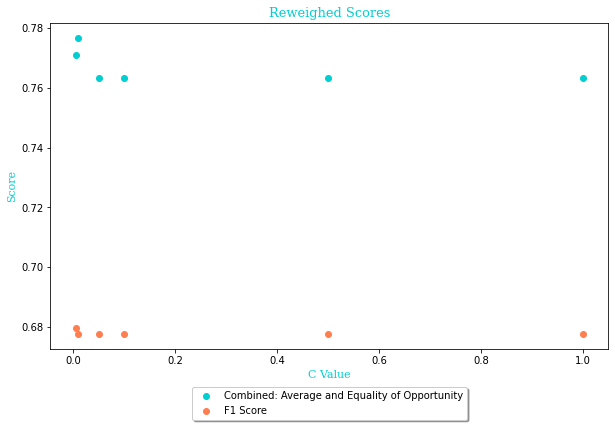

In [57]:
rw_fairaccuracyf1(X_train_a, y_train_a, a_train, c)

Best accuracy score is at C:  0.014799999999999997 with accuracy score of 0.7884409465674679
Best Equality of Opportunity score is at C:  0.004 with an equality of opportunity score of -0.0021185994499224314
Best f1 score is at C:  0.004 with a score of 0.6797792820673395
Best combined score is at C:  0.004 with a score of 0.7859421147027172


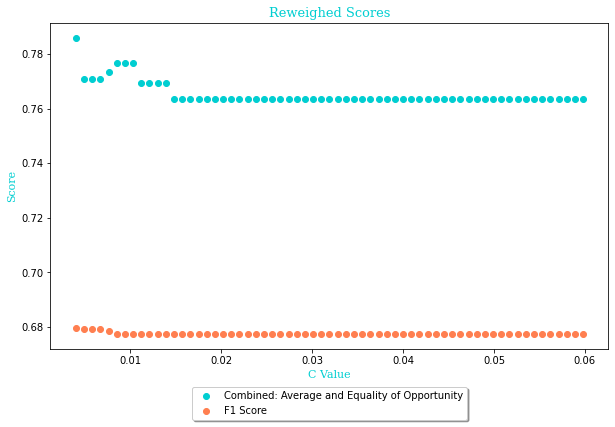

In [58]:
rw_fairaccuracyf1(X_train_a, y_train_a, a_train, np.arange(0.004, 0.06, 0.0009))

Best accuracy score is at C:  0.001 with accuracy score of 0.7891137006660291
Best Equality of Opportunity score is at C:  0.0031600000000000005 with an equality of opportunity score of -0.0021185994499224314
Best f1 score is at C:  0.001 with a score of 0.6830599074062617
Best combined score is at C:  0.0031600000000000005 with a score of 0.7859421147027172


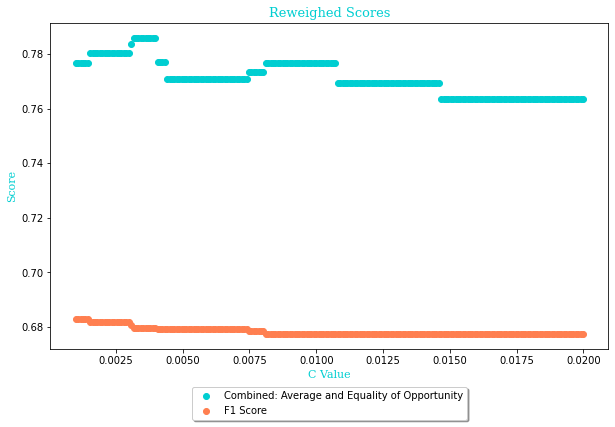

In [59]:
rw_fairaccuracyf1(X_train_a, y_train_a, a_train, np.arange(0.001, 0.02, 0.00009))

### German

Best accuracy score is at C:  0.5 with accuracy score of 0.7128571428571429
Best Equality of Opportunity score is at C:  0.01 with an equality of opportunity score of 0.0031311154598824276
Best f1 score is at C:  0.005 with a score of 0.5257516199573378
Best combined score is at C:  0.005 with a score of 0.7040900195694717


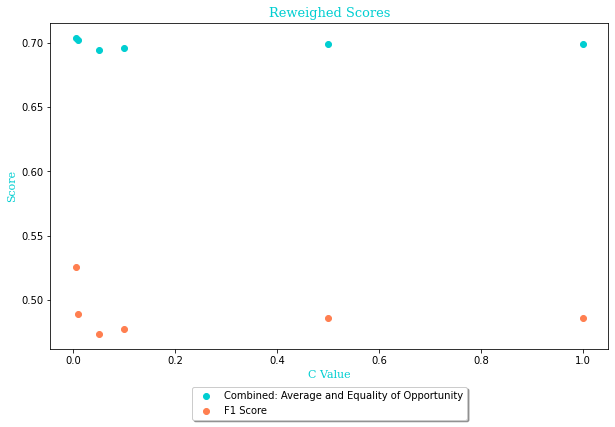

In [60]:
rw_fairaccuracyf1(X_train_g, y_train_g, g_train, c)

Best accuracy score is at C:  0.0019 with accuracy score of 0.7214285714285714
Best Equality of Opportunity score is at C:  0.0271 with an equality of opportunity score of -0.000684931506849451
Best f1 score is at C:  0.0019 with a score of 0.5726776674774834
Best combined score is at C:  0.0046 with a score of 0.7063796477495106


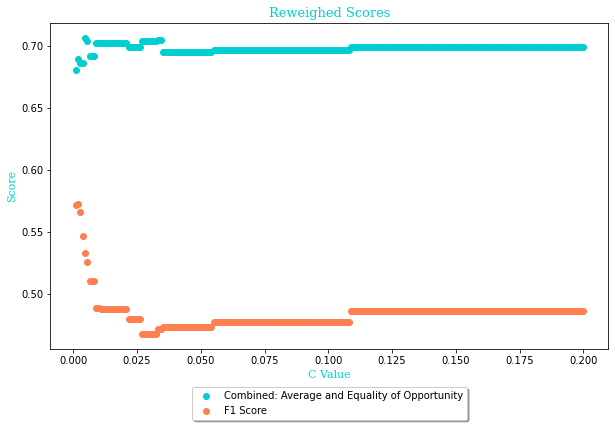

In [61]:
rw_fairaccuracyf1(X_train_g, y_train_g, g_train, np.arange(0.001, 0.2, 0.0009) )

## Task 3a: Compute and Report the Final Scores

### Adult

<font color='darkviolet'> **(5a) Standard Logistic Regression Model**</font>

In [62]:
finalscores(X_train_a, y_train_a, X_test_a, y_test_a, a_test, 0.01)

The final Accuracy score on the test data with hyperparameter C: 0.01 is 0.8039991810550741
The final Equality of Opportunity score at C: 0.01 is [-0.4581379772270596]
The disparate impact score is [0.0]


> The <font color='darkviolet'>**final *accuracy* score**</font> in testing data at hyperparameter C: 0.01 is <font color='darkviolet'>**0.8040**</font> and the <font color='darkviolet'>**final *Equality of Opportunity* score**</font> is <font color='darkviolet'>**-0.45814**</font>



<font color='darkturquoise'> **(6a) Fairness-based Logistic Regression Model**</font>

In [63]:
rw_finalscores(X_train_a, y_train_a, X_test_a, y_test_a,a_train, a_test, 0.032)

After reweighing, the final accuracy score on the test data with hyperparameter C: 0.032 is 0.7909643076503106
The Equality of Opportunity score at C: 0.032 is [0.02028996011236517]
The disparate impact score is [0.6827554035209011]


> The <font color='darkturquoise'>**final *accuracy* score**</font> in testing data at hyperparameter C: 0.032 is <font color='darkturquoise'>**0.79096**</font> and the <font color='darkturquoise'>**final *Equality of Opportunity* score**</font> is <font color='darkturquoise'>**-0.02029**</font>

### German

<font color='darkviolet'> **(5a) Standard Logistic Regression Model**</font>

In [64]:
finalscores(X_train_g, y_train_g, X_test_g, y_test_g, g_test, 0.051)

The final Accuracy score on the test data with hyperparameter C: 0.051 is 0.6466666666666666
The final Equality of Opportunity score at C: 0.051 is [-0.1504771225838023]
The disparate impact score is [0.7754407051282051]


> The <font color='darkviolet'>**final *accuracy* score**</font> in testing data at hyperparameter C: 0.051 is <font color='darkviolet'>**0.646667**</font> and the <font color='darkviolet'>**final *Equality of Opportunity* score**</font> is <font color='darkviolet'>**-0.150477**</font>

<font color='darkturquoise'> **(6a) Fairness-based Logistic Regression Model**</font>

In [65]:
rw_finalscores(X_train_g, y_train_g, X_test_g, y_test_g,g_train, g_test, 0.046)

After reweighing, the final accuracy score on the test data with hyperparameter C: 0.046 is 0.6366666666666667
The Equality of Opportunity score at C: 0.046 is [-0.002936138977244984]
The disparate impact score is [0.9815705128205129]


> The <font color='darkturquoise'>**final *accuracy* score**</font> in testing data at hyperparameter C: 0.046 is <font color='darkturquoise'>**0.636667**</font> and the <font color='darkturquoise'>**final *Equality of Opportunity* score**</font> is <font color='darkturquoise'>**-0.00294**</font>

# **Task 3b (Extra)** 

This task will be using the metric *F1 Score* in the combined score to work out the optimal model. 

## (5b) Standard Machine Learning Model 

### Functions

In [66]:
#need to find a sweetspot between the fairness and accuracy
#we want high accuracy and low equal opp 
#we would then want high 1-(low equal opp)
#add (accuracy and high 1-(low equal opp)) - 1 would be the best combined score

#looking into the f1 score 

def fairf1combined(X_train, y_train, train, cvals):
  #empty lists for our scores
  fairness = []
  equ_opp = []
  f1score = []

#looping through each C value
  for i in cvals:
    #our model
    clf = LogisticRegression(solver='liblinear', C=i, random_state=1)
    #accuracy score
    score = cross_val_score(clf, X_train, y_train, cv = 5)
    #prediction labels for fairness
    fair_pred = cross_val_predict(clf, X_train, y_train, cv = 5)
    test_pred = train.copy()
    test_pred.labels = fair_pred

    #defining our metric
    metric = ClassificationMetric(train, test_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

    #recording the scores
    equ_opp.append(metric.equal_opportunity_difference())
    f1score.append(f1_score(y_train, fair_pred, average = 'macro'))

  #taking the absolute value for the Equality of Opportunity scores
  absol_equ_opp = []
  for value in equ_opp:
    absolute = abs(value)
    absol_equ_opp.append(absolute)

  #combining the values of f1 scoreand Equality of Opportunity
  combined = [(1-j) + k for (j, k) in zip(absol_equ_opp, f1score)]


  #re-scaling the combined value to be out of 1, closer to 1 is better
  rescaledcombined = []
  for value in combined:
    rescaled = value - 1
    rescaledcombined.append(rescaled)
  
  best_c = equ_opp.index(min(equ_opp, key= abs)) #we want this to be closest to 0
  best_combined = rescaledcombined.index(max(rescaledcombined)) # we want this to be 1
  best_f1 = f1score.index(max(f1score)) #we want f1 score to be 1

  #printing the values
  print('Best Equality of Opportunity score is at C: ', cvals[best_c], 'with an equality of opportunity score of', min(equ_opp, key= abs))
  print('Best f1 score is at C: ', cvals[best_f1], 'with a score of', max(f1score))
  print('Best combined score is at C: ', cvals[best_combined], 'with a score of', max(rescaledcombined))
  
  #plotting the graph
  xplt = cvals
  plt.figure(figsize = (10,6))
  plt.scatter(xplt, rescaledcombined, color = 'darkgreen', label = 'Combined: Average, F1 and Equality of Opportunity Scores')
  plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.10),
          fancybox=True, shadow=True)

  font1 = {'family':'serif','color':'darkgreen','size':13}
  font2 = {'family':'serif','color':'darkgreen','size':11}
  plt.title('Combined Scores', fontdict = font1, color = 'darkviolet')
  plt.xlabel('C Value', fontdict = font2)
  plt.ylabel('Score', fontdict = font2)
  plt.show()
  

  #return(df) 

### Adult 

Best Equality of Opportunity score is at C:  0.001 with an equality of opportunity score of -0.4464800923254472
Best f1 score is at C:  0.017 with a score of 0.6829809555455333
Best combined score is at C:  0.001 with a score of 0.23314021908236526


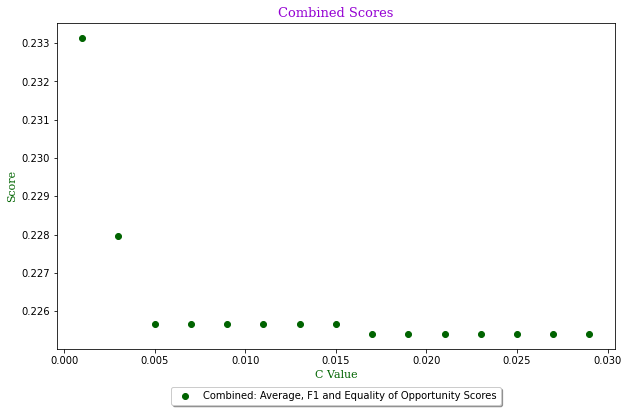

In [67]:
fairf1combined(X_train_a, y_train_a, a_train, np.arange(0.001, 0.03, 0.002))

### German

Best Equality of Opportunity score is at C:  0.05 with an equality of opportunity score of -0.050097847358121395
Best f1 score is at C:  0.005 with a score of 0.5569887959190813
Best combined score is at C:  0.005 with a score of 0.49250738691712437


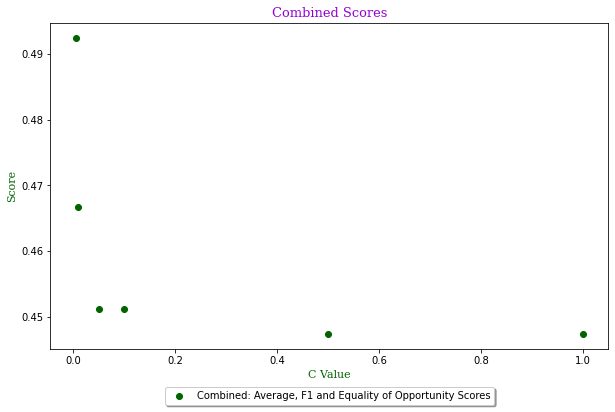

In [68]:
fairf1combined(X_train_g, y_train_g, g_train, c)

Best Equality of Opportunity score is at C:  0.051000000000000004 with an equality of opportunity score of -0.050097847358121395
Best f1 score is at C:  0.001 with a score of 0.5719406041986688
Best combined score is at C:  0.003 with a score of 0.5159089955736154


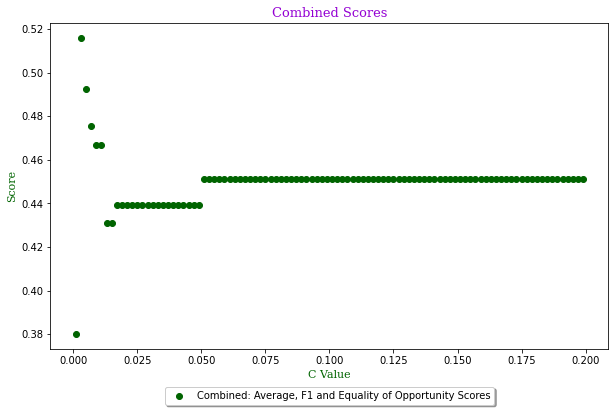

In [69]:
fairf1combined(X_train_g, y_train_g, g_train, np.arange(0.001, 0.2, 0.002))

## (6b) Fairness-based Machine Learning Model

### Functions

In [70]:
#need to find a sweetspot between the fairness and accuracy
#we want high accuracy and low equal opp 
#we would then want high 1-(low equal opp)
#add (accuracy and high 1-(low equal opp)) - 1 would be the best combined score

#looking into the f1 score 

def rw_fairaccuracyf1combined(X_train, y_train, train, cvals):
  #empty lists for our scores
  fairness = []
  equ_opp = []
  f1score = []
  #mitgating the bias
  #assigning the new weights to the unprivileged and privileged groups, transform the dataset with reweighing
  RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
  #obtaining a set of weights for the training set
  train = RW.fit_transform(train)


#looping through each C value
  for i in cvals:
    #our model
    clf = LogisticRegression(solver='liblinear', C=i, random_state=1)
    #accuracy score
    score = cross_val_score(clf, X_train, y_train, fit_params={'sample_weight': train.instance_weights}, cv = 5)
    #prediction labels for fairness
    fair_pred = cross_val_predict(clf, X_train, y_train, fit_params={'sample_weight': train.instance_weights}, cv = 5)
    test_pred = train.copy()
    test_pred.labels = fair_pred

    #defining our metric
    metric = ClassificationMetric(train, test_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

    #recording the scores
    equ_opp.append(metric.equal_opportunity_difference())
    f1score.append(f1_score(y_train, fair_pred, average = 'macro'))

  #taking the absolute value for the Equality of Opportunity scores
  absol_equ_opp = []
  for value in equ_opp:
    absolute = abs(value)
    absol_equ_opp.append(absolute)

  #combining the values of accuracy and Equality of Opportunity
  combined = [(1-j) + k for (j, k) in zip(absol_equ_opp, f1score)]


  #re-scaling the combined value to be out of 1, closer to 1 is better
  rescaledcombined = []
  for value in combined:
    rescaled = value - 1
    rescaledcombined.append(rescaled)
  
  best_c = equ_opp.index(min(equ_opp, key= abs))
  best_combined = rescaledcombined.index(max(rescaledcombined)) # we want this to be 
  best_f1 = f1score.index(max(f1score)) #we want f1 score to be 1

  print('Best Equality of Opportunity score is at C: ', cvals[best_c], 'with an equality of opportunity score of', min(equ_opp, key= abs))
  print('Best f1 score is at C: ', cvals[best_f1], 'with a score of', max(f1score))
  print('Best combined score is at C: ', cvals[best_combined], 'with a score of', max(rescaledcombined))

  #pltting the results
  xplt = cvals
  plt.figure(figsize = (10,6))
  plt.scatter(xplt, rescaledcombined, color = 'magenta', label = 'Combined: Average, F1 and Equality of Opportunity Scores')
  plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.10),
          fancybox=True, shadow=True)

  font1 = {'family':'serif','color':'magenta','size':13}
  font2 = {'family':'serif','color':'magenta','size':11}
  plt.title('Combined Scores', fontdict = font1, color = 'magenta')
  plt.xlabel('C Value', fontdict = font2)
  plt.ylabel('Score', fontdict = font2)
  plt.show()

  #return(df) 


### Adult

Best Equality of Opportunity score is at C:  0.01 with an equality of opportunity score of -0.011180795108922947
Best f1 score is at C:  0.005 with a score of 0.6794571444787936
Best combined score is at C:  0.01 with a score of 0.6663937880442259


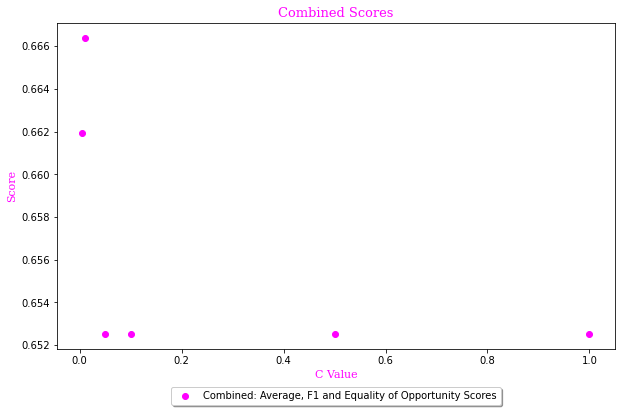

In [71]:
#calculating the combined score on the reweighed with a broad c


rw_fairaccuracyf1combined(X_train_a, y_train_a, a_train, c)

Best Equality of Opportunity score is at C:  0.009000000000000001 with an equality of opportunity score of -0.011180795108922947
Best f1 score is at C:  0.005 with a score of 0.6794571444787936
Best combined score is at C:  0.009000000000000001 with a score of 0.6663937880442259


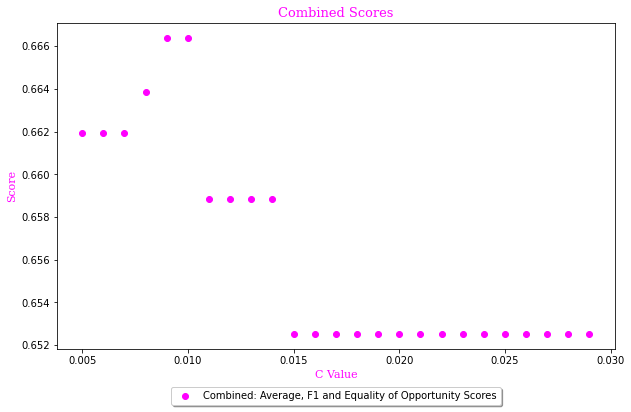

In [72]:
#narrowing in to more specific cs

rw_fairaccuracyf1combined(X_train_a, y_train_a, a_train, np.arange(0.005, 0.03, 0.001))

### German

Best Equality of Opportunity score is at C:  0.01 with an equality of opportunity score of 0.0031311154598824276
Best f1 score is at C:  0.005 with a score of 0.5257516199573378
Best combined score is at C:  0.005 with a score of 0.518413068098238


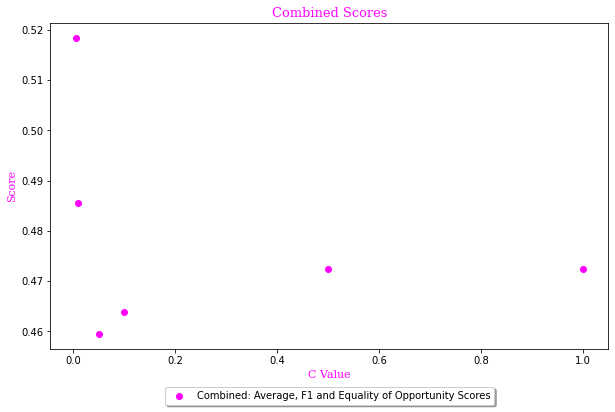

In [73]:
#calculating the combined score on the reweighed with a broad c

rw_fairaccuracyf1combined(X_train_g, y_train_g, g_train, c)

Best Equality of Opportunity score is at C:  0.009000000000000001 with an equality of opportunity score of 0.0031311154598824276
Best f1 score is at C:  0.002 with a score of 0.5726776674774834
Best combined score is at C:  0.002 with a score of 0.540583734013687


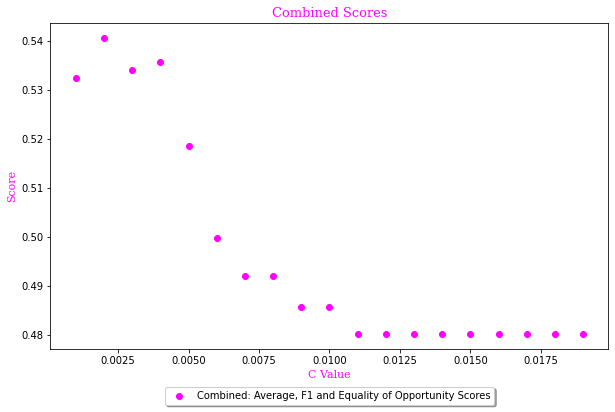

In [74]:
#narrowing in to more specific cs

rw_fairaccuracyf1combined(X_train_g, y_train_g, g_train, np.arange(0.001, 0.02, 0.001))

## Task 3b: Compute and Report the Final Scores

### Adult

<font color='darkgreen'> **(5a) Standard Logistic Regression Model**</font>


In [75]:
#calculating the final scores

finalscores(X_train_a, y_train_a, X_test_a, y_test_a, a_test, 0.001)

The final Accuracy score on the test data with hyperparameter C: 0.001 is 0.8042721626970586
The final Equality of Opportunity score at C: 0.001 is [-0.4511051574012056]
The disparate impact score is [0.0]


> The <font color='darkgreen'>**final *accuracy* score**</font> in testing data at hyperparameter C: 0.001 is <font color='darkgreen'>**0.8043**</font> and the <font color='darkgreen'>**final *Equality of Opportunity* score**</font> is <font color='darkgreen'>**-0.4511**</font>

<font color='magenta'> **(6b) Fairness-based Machine Learning Model** </font>

In [76]:
#caluclating the final scores for the reweighed

rw_finalscores(X_train_a, y_train_a, X_test_a, y_test_a,a_train, a_test, 0.009)

After reweighing, the final accuracy score on the test data with hyperparameter C: 0.009 is 0.7909643076503106
The Equality of Opportunity score at C: 0.009 is [0.02028996011236517]
The disparate impact score is [0.6827554035209011]


> The <font color='magenta'>**final *accuracy* score**</font> in testing data at hyperparameter C: 0.009 is <font color='magenta'>**0.79096**</font> and the <font color='magenta'>**final *Equality of Opportunity* score**</font> is <font color='magenta'>**0.02029**</font>

### German

<font color='darkgreen'> **(5a) Standard Logistic Regression Model**</font>


In [77]:
#calculating the final scores

finalscores(X_train_g, y_train_g, X_test_g, y_test_g, g_test, 0.003)

The final Accuracy score on the test data with hyperparameter C: 0.003 is 0.6566666666666666
The final Equality of Opportunity score at C: 0.003 is [-0.1355517494494739]
The disparate impact score is [0.8047817047817047]


> The <font color='darkgreen'>**final *accuracy* score**</font> in testing data at hyperparameter C: 0.003 is <font color='darkgreen'>**0.6567**</font> and the <font color='darkgreen'>**final *Equality of Opportunity* score**</font> is <font color='darkgreen'>**-0.1355**</font>

<font color='magenta'> **(6b) Fairness-based Machine Learning Model** </font>

In [78]:
#calculating the final scores for the reweighed

rw_finalscores(X_train_g, y_train_g, X_test_g, y_test_g,g_train, g_test, 0.002)

After reweighing, the final accuracy score on the test data with hyperparameter C: 0.002 is 0.66
The Equality of Opportunity score at C: 0.002 is [-0.06398336187912901]
The disparate impact score is [0.869017094017094]


> The <font color='magenta'>**final *accuracy* score**</font> in testing data at hyperparameter C: 0.002 is <font color='magenta'>**0.66**</font> and the <font color='magenta'>**final *Equality of Opportunity* score**</font> is <font color='magenta'>**-0.06398**</font>